In [1]:
import pandas as pd
import numpy as np

import datetime
import time

from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
data_features = pd.read_csv('features.csv', sep='\t')
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_test.csv')

Wall time: 2min 5s


Исследование датасетов на нулевые значения

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  831653 non-null  int64  
 1   id          831653 non-null  int64  
 2   vas_id      831653 non-null  float64
 3   buy_time    831653 non-null  int64  
 4   target      831653 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 31.7 MB


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  71231 non-null  int64  
 1   id          71231 non-null  int64  
 2   vas_id      71231 non-null  float64
 3   buy_time    71231 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 2.2 MB


Исследование распределения целефой переменной

In [5]:
data_train.target.value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

Посмотрим на распределение количества подключений по датам.

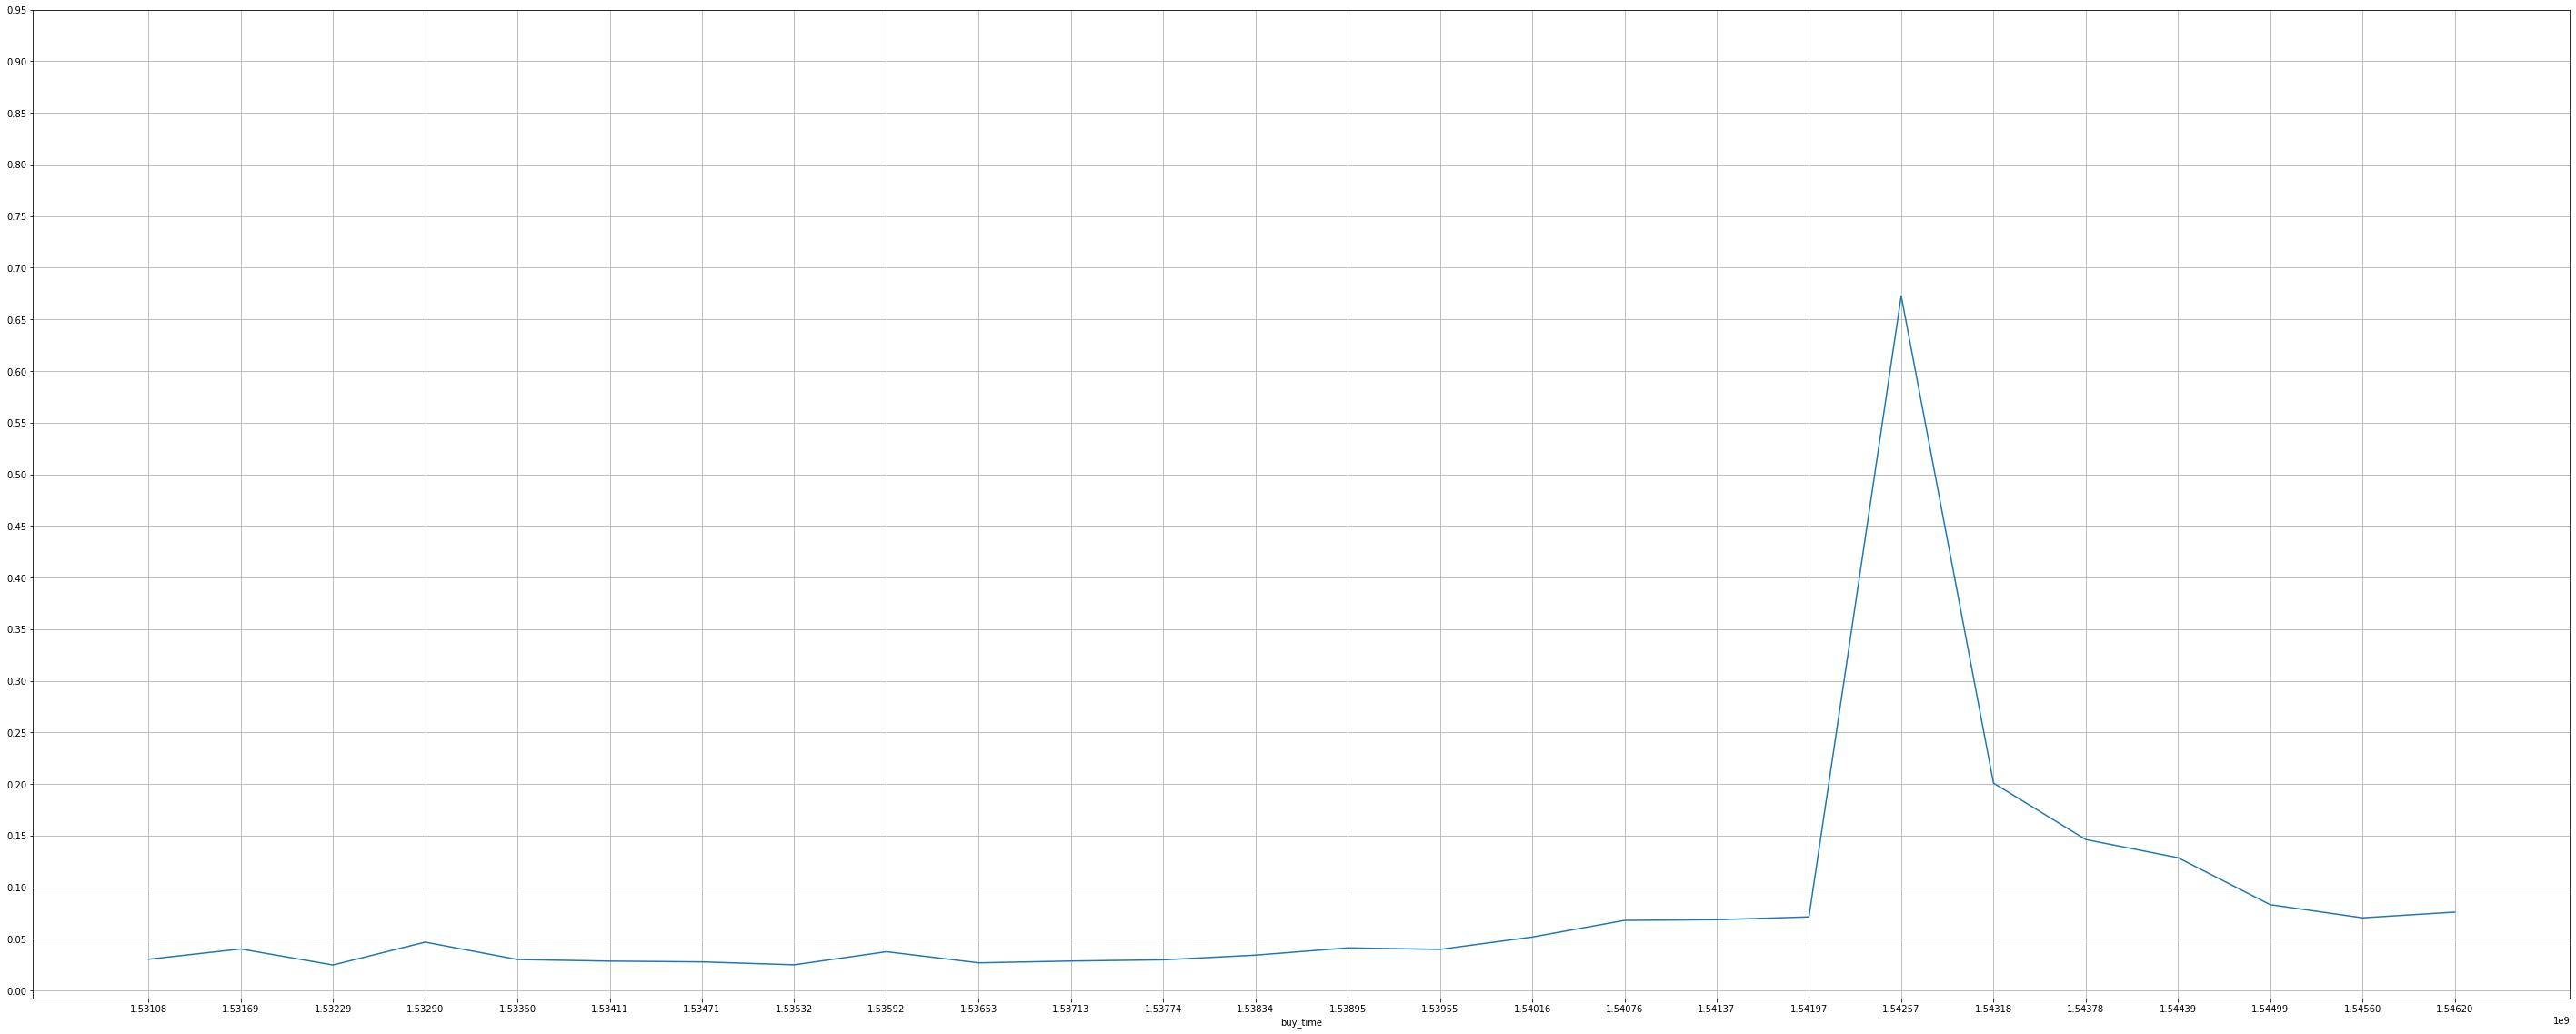

In [46]:
plt.figure(figsize=(50, 20))
data_train.groupby(['buy_time'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(data_train['buy_time'].unique())
plt.yticks(np.arange(0, 1, 0.05))
plt.grid()
plt.show()

In [7]:
start = 1.54197e9
datetime.date.fromtimestamp(start)

datetime.date(2018, 11, 12)

In [8]:
finish = 1.54439e9
datetime.date.fromtimestamp(finish)

datetime.date(2018, 12, 10)

Видно, что 4 недели пользователи особенно активно подключались. Для корректности предсказаний, я уберу этот период из тренировочного датасета.

In [9]:
cutted_train = data_train[(data_train.buy_time < start) | (data_train.buy_time > finish)]

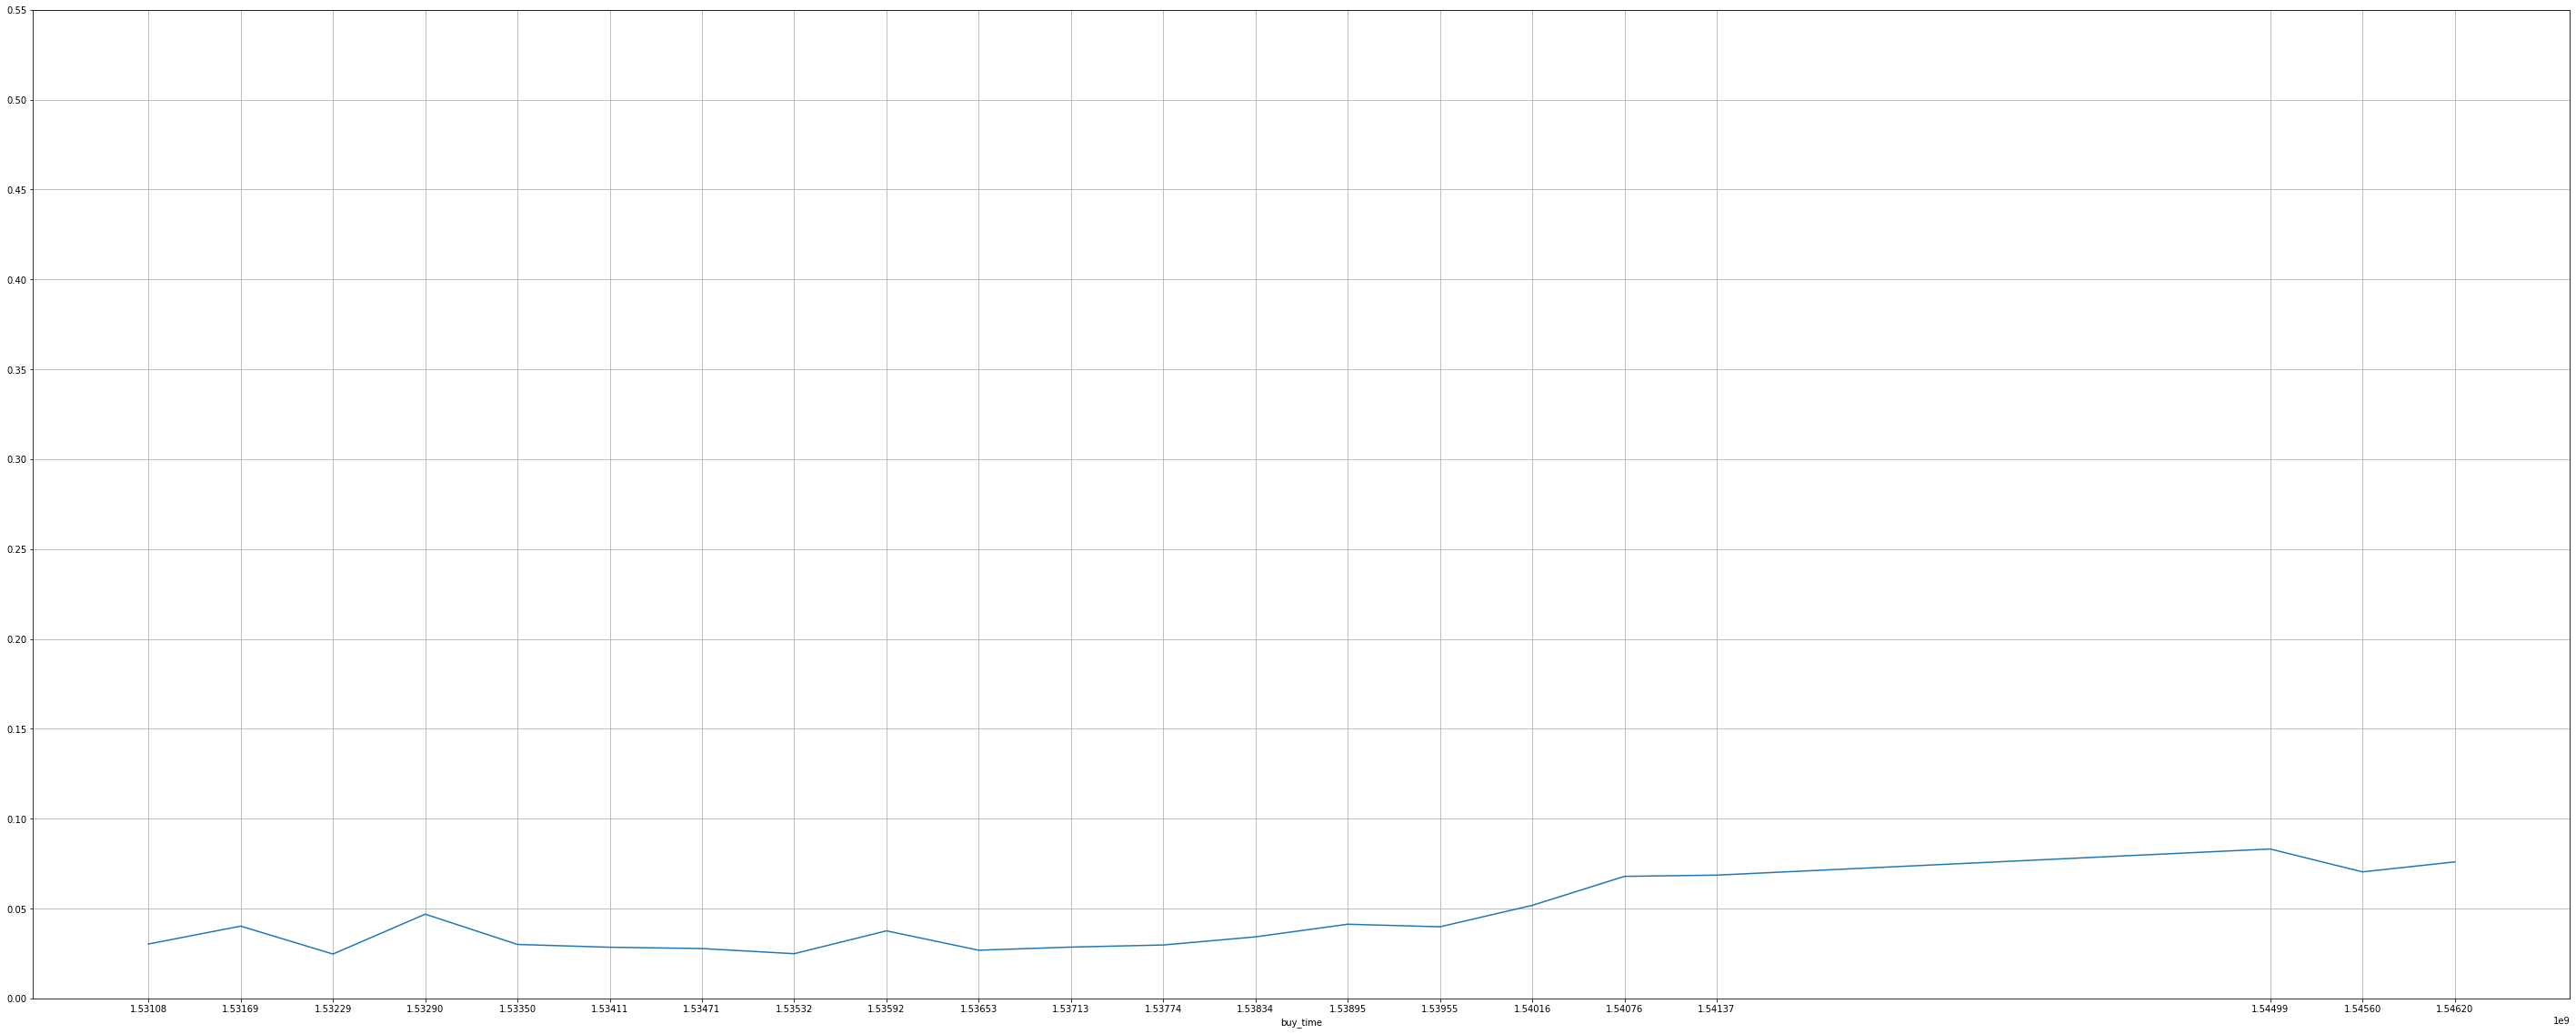

In [10]:
plt.figure(figsize=(50, 20))
cutted_train.groupby(['buy_time'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(cutted_train['buy_time'].unique())
plt.yticks(np.arange(0, 0.6, 0.05))
plt.grid()
plt.show()

Повторные абоненты:

In [11]:
cutted_train.id.shape[0] - pd.unique(cutted_train.id).shape[0]

9429

Оставим только уникальных.

In [12]:
user_ids = np.unique(cutted_train['id'].append(data_test['id']))
data_features = data_features[data_features['id'].isin(user_ids)]

In [13]:
cutted_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [14]:
data_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [15]:
data_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
16,16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
27,27,2085648,1539550800,68.440029,260.430888,54.499214,207.823202,49.081754,186.71821,13.59382,...,2668.626154,3032.229208,-25.996269,-24.630448,-60.747724,-6.832889,-0.694428,-5.175933,-0.45614,0.0
33,33,2102126,1538341200,199.810029,185.010888,196.039214,172.243202,444.011754,404.52821,-16.08618,...,-974.373846,-613.770792,-25.996269,-15.630448,40.252276,-8.832889,-0.694428,4.824067,-0.45614,1.0


Drop 'Unnamed: 0' column.

In [16]:
cutted_train = cutted_train.drop(columns='Unnamed: 0')
data_test = data_test.drop(columns='Unnamed: 0')
data_features = data_features.drop(columns='Unnamed: 0')

In [17]:
complete_train = cutted_train.merge(data_features, on='id', how = 'left')
complete_test = data_test.merge(data_features, on='id', how = 'left')

In [18]:
complete_train.head()

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,0.0,1543179600,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,0.0,1533502800,54.880029,12.970888,54.079214,-9.116798,48.661754,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,0.0,1543179600,45.160029,295.240888,64.679214,344.283202,59.261754,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [19]:
complete_test.head()

,id,vas_id,buy_time_x,buy_time_y,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.0,1548018000,1536526800,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,...,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2000860,4.0,1548018000,1532293200,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,...,-977.373846,-613.770792,-25.996269,-37.630448,-254.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,1099444,2.0,1546808400,1541365200,-81.969971,-390.729112,-95.910786,-443.336798,-101.328246,-464.44179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
3,1343255,5.0,1547413200,1536526800,259.130029,-52.249112,245.189214,-104.856798,239.771754,-125.96179,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
4,1277040,2.0,1546808400,1532293200,331.170029,590.890888,317.229214,538.283202,311.811754,522.25821,...,-651.373846,-612.770792,1.003731,-36.630448,38.252276,-12.832889,-0.694428,-12.175933,12.54386,0.0


In [20]:
X = complete_train.drop('target', axis='columns')
y = complete_train.target
X_valid = complete_test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((599899, 257), (149975, 257), (599899,), (149975,))

In [22]:
features = [f for f in complete_train.columns if f not in ['target', 'id']]

In [23]:
boolean_features = []
categorical_features = []
numeric_features = []
for col in X[features].fillna(0):
    val_count = len(X[col].unique())
    if val_count == 2:
        boolean_features.append(col)
    elif val_count <= 10:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [25]:
new_features_list = ['interval']

In [ ]:
class FeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, features_list):
        self.features_list = features_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if 'interval' in self.features_list:
            X['interval'] = X['buy_time_y'] - X['buy_time_x']

        return X

In [27]:
num_pipe = Pipeline([
    ('ncs', ColumnSelector(columns=numeric_features)),
    ('nsi', SimpleImputer(strategy="mean")),
    ('nss', StandardScaler()),
])

cat_pipe = Pipeline([
    ('ccs', ColumnSelector(columns=categorical_features)),
    ('csi', SimpleImputer(strategy="most_frequent")),
    ('coe', OneHotEncoder(handle_unknown='ignore')),
])

bool_pipe = Pipeline([
    ('bcs', ColumnSelector(columns=boolean_features)),
    ('bsi', SimpleImputer(strategy="most_frequent")),
])

transformer_list = [('num_pipe', num_pipe), ('cat_pipe', cat_pipe), ('bool_pipe', bool_pipe)]

transform_pipe = Pipeline([
    ('cs', ColumnSelector(columns=features)),
    ('fg', FeaturesGenerator(features_list=['interval'])),
    ('fu', FeatureUnion(transformer_list=transformer_list)),
])

In [28]:
fs_pipe = make_pipeline(
    transform_pipe,
    SelectKBest(k=50, score_func=f_classif),
    SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42), threshold=1e-3),
)

In [29]:
X_train.describe()

,id,vas_id,buy_time_x,buy_time_y,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
count,5.998990e+05,599899.000000,5.998990e+05,5.998990e+05,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,...,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000,599899.000000
mean,2.172371e+06,2.581109,1.538279e+09,1.539591e+09,-0.166660,-0.090962,-0.350170,-0.242560,-0.341608,-0.251815,...,-0.074362,-1.325087,-0.029708,-0.215017,-2.126899,0.124244,-0.022835,0.057463,-0.000166,0.258920
std,1.258454e+06,1.915076,5.040648e+06,5.318774e+06,189.731682,441.051364,199.726996,493.181983,218.056080,555.538183,...,3203.261688,2236.540443,1490.499641,291.322428,1307.815666,283.339292,8.846643,220.576865,13.224410,2.397754
min,2.000000e+00,1.000000,1.531084e+09,1.531084e+09,-1151.889971,-1594.119112,-2651.840786,-1634.436798,-2657.258246,-1655.541790,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
25%,1.081676e+06,1.000000,1.533503e+09,1.534712e+09,-96.799971,-209.739112,-110.740786,-243.306798,-116.158246,-260.701790,...,-977.373846,-613.770792,-25.996269,-37.630448,-305.747724,-25.832889,-0.694428,-12.175933,-0.456140,0.000000
50%,2.166552e+06,2.000000,1.537132e+09,1.539551e+09,-84.939971,-60.719112,-85.310786,-79.426798,-87.778246,-93.921790,...,-959.373846,-613.770792,-25.996269,-37.630448,-239.747724,-23.832889,-0.694428,-12.175933,-0.456140,0.000000
75%,3.262254e+06,4.000000,1.544994e+09,1.544994e+09,11.540029,118.490888,26.969214,126.063202,28.351754,119.638210,...,-486.373846,-409.770792,-24.996269,-33.630448,-78.747724,-10.832889,-0.694428,-9.175933,-0.456140,1.000000
max,4.362684e+06,9.000000,1.546204e+09,1.548018e+09,29005.170029,174842.540888,29026.789214,174791.193202,29021.371754,174770.088210,...,240076.626154,145602.229208,980158.003731,38833.369552,185850.252276,138539.167111,3865.305572,138552.824067,9489.543860,1743.000000


In [30]:
%%time
fs_pipe.fit(X_train, y_train)

Wall time: 17min 13s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('cs',
                                  ColumnSelector(columns=['vas_id',
                                                          'buy_time_x',
                                                          'buy_time_y', '0',
                                                          '1', '2', '3', '4',
                                                          '5', '6', '7', '8',
                                                          '9', '10', '11', '12',
                                                          '13', '14', '15',
                                                          '16', '17', '18',
                                                          '19', '20', '21',
                                                          '22', '23', '24',
                                                          '25', '26', ...])),
                                 ('fg',
                                  FeaturesGenerator(fea

In [31]:
X_test_transform = fs_pipe.transform(X_test)
X_train_transform = fs_pipe.transform(X_train)
X_valid_transform = fs_pipe.transform(X_valid)

In [32]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [33]:
model = CatBoostClassifier(random_state=42, verbose=False)

In [34]:
model.fit(X_ros, y_ros)

In [35]:
y_test_pred = model.predict(X_test)

In [36]:
f1_score(y_test, y_test_pred, average='macro')

0.6755628664396605

In [37]:
y_valid = model.predict(X_valid)

In [39]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [48]:
answer_test = X_valid[['id', 'vas_id', 'buy_time_x']]

In [49]:
answer_test['activation_pred'] = y_valid

In [50]:
answer_test.to_csv('answers_test.csv', index=False)